In [1]:
from game_board import GameBoard
from game_state import Player, GameState, QMap
from strateegery import Strateegery

from time import time
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import pickle

from play import LearningPlayer, setupGame, getRatios, fightDuels, playGames, trainQ, graphStats, printTally
%matplotlib inline

Data Exploration/Visualization
--------------------

**Approximate baseline win/draw/loss ratios using random policy:**

On the cell bellow the proportions of the actual game counts for 3x3 tictactoe, i.e;  

91/138 : 3/138 : 44/138

are compared to the simulated ratios:  

(total # player 1 wins)/10000 : (total # draws)/10000 : (total # player 2 wins)/10000  

As noted on the report the proportion of draws increases with size of the game.

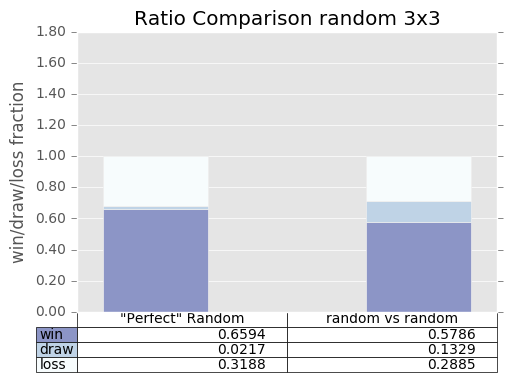

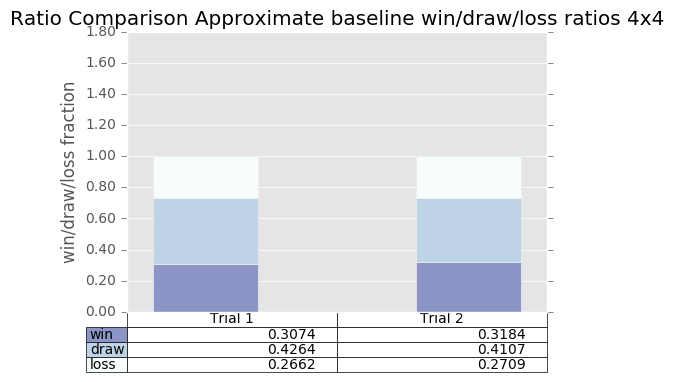

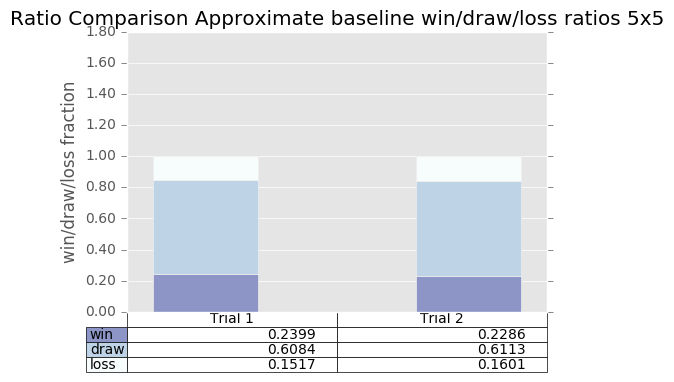

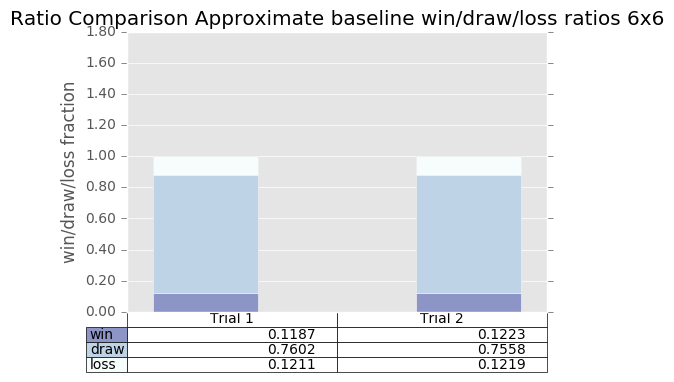

In [3]:
###############################################################
# Approximate baseline win/draw/loss ratios using random policy

if __name__ == '__main__': 
    size = 3
    columns  = ('"Perfect" Random', 'random vs random')
    
    # TicTacToe X-O win/loss/draw ratio: 91:44:3 or 0.6594 : 0.31884 : 0.0217, source wikipedia
    ratios = [[91.0/138, 3.0/138, 44.0/138 ]]
    ratios += fightDuels([QMap()], [['random', 'random']], size, n_games = 10000)

    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'random 3x3')

    ##
    size = 4
    columns = ('Trial 1', 'Trial 2')
    ratios = np.transpose(fightDuels([QMap(), QMap()], [ ['random','random'], ['random','random'] ], size, 10000))

    graphStats(columns, ratios, 'Approximate baseline win/draw/loss ratios 4x4')

    ## 
    size = 5
    columns = ('Trial 1', 'Trial 2')
    ratios = np.transpose(fightDuels([QMap(), QMap()], [ ['random','random'], ['random','random'] ], size, 10000))

    graphStats(columns, ratios, 'Approximate baseline win/draw/loss ratios 5x5')

    ##
    size = 6
    columns = ('Trial 1', 'Trial 2')
    ratios = np.transpose(fightDuels([QMap(), QMap()], [ ['random','random'], ['random','random'] ], size, 10000))

    graphStats(columns, ratios, 'Approximate baseline win/draw/loss ratios 6x6')

Algorithms and Techniques
----------------------------

**Ideal policy baseline comparison**

The ratios of actual counts of a non-losing player wins to draws of 3x3 tictactoe i.e.;

91/94 : 3/94 as player 1 
44/47 : 3/47 as player 2

Are compared to 1000 games of the Ideal policy vs random, both as player 1 and player 2. As discussed in the  
report, Ideal tends to be stronger than expected as player 1 and weaker than expected as player 2. However in
never loses.

6.10338282585


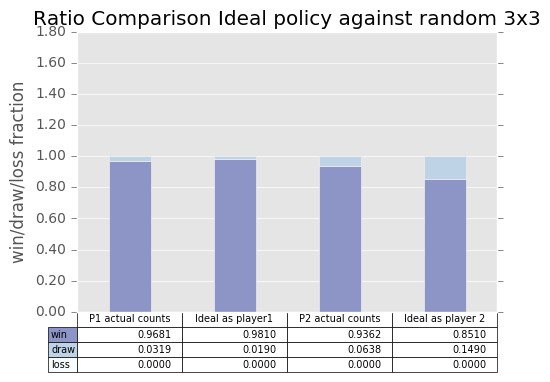

In [4]:
#########################
# Ideal policy stats 3x3
if __name__ == '__main__':  
    size = 3
    start = time()
    columns  = ('P1 actual counts', 'Ideal as player1', 'P2 actual counts', 'Ideal as player 2')

    # Perfect X player 3x3 win/draw/loss ratio 91:3:0 or 0.9681 : 0.0319 : 0  
    ratios = [[ 91./94, 3.0/94, 0/94]]
    ratios += fightDuels([QMap()], [['ideal', 'random']], size, n_games = 1000)

    # Perfect O player 3x3 win/draw/loss ratio 0:3:44 or 0.9363 :0.0638 : 0
    ratios.append([ 44.0/47, 3.0/47, 0/47 ])
    
    # This guy needs to be reversed because we are interested in player2 wins
    ratios.append(fightDuels([QMap()], [['random', 'ideal']], size, n_games = 1000)[0][::-1] )
    
    print time() - start
    graphStats(columns, np.transpose(ratios), 'Ideal policy against random 3x3')
    

**Minimax policy baseline comparison**

The ratios of actual counts of a non-losing player wins to draws of 3x3 tictactoe i.e.;

91/94 : 3/94 as player 1 
44/47 : 3/47 as player 2

Are compared to 500 games of the minimax policy vs random, both as player 1 and player 2. Minimax as player 1  
is closer to the expected ratio, and similarly to Ideal shows more weakness than expected as player 2. It also  
suffers a small number of losses as player 2, but as described in the report this is most likely an implementation  
failure since it must be run at an exploration depth of 2 to keep its running time reasonable.

79.1864280701


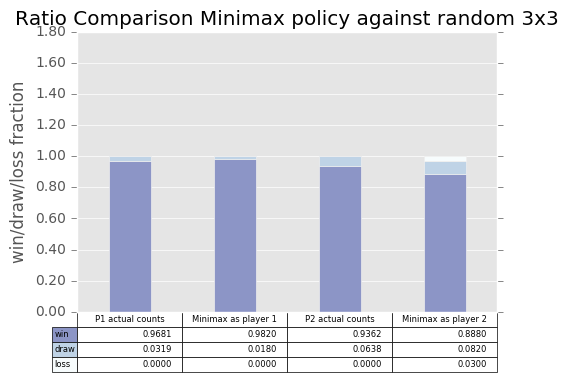

In [5]:
###########################
# Minimax policy stats 3x3

if __name__ == '__main__':
    size = 3
    columns  = ('P1 actual counts', 'Minimax as player 1', 'P2 actual counts', 'Minimax as player 2')
    start = time()
    # Perfect X player 3x3 win/draw/loss ratio 91:3:0 or 0.9681 : 0.0319 : 0  
    ratios  = [[ 91./94, 3.0/94, 0/94]]
    ratios += fightDuels([QMap()], [['minimax', 'random']], size, n_games = 500)
         
    # Perfect O player 3x3 win/draw/loss ratio 0:3:44 or 0.9363 :0.0638 : 0
    ratios.append([ 44./47, 3.0/47, 0/47 ])

    # This guy needs to be reversed because we are interested in player2 wins
    ratios.append(fightDuels([QMap()], [['random', 'minimax']], size, n_games = 500)[0][::-1])
    
    print time() - start        
    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'Minimax policy against random 3x3')

CONVERGENCE ON GAME NUMBER:  0
CONVERGENCE ON GAME NUMBER:  0
43.8427410126


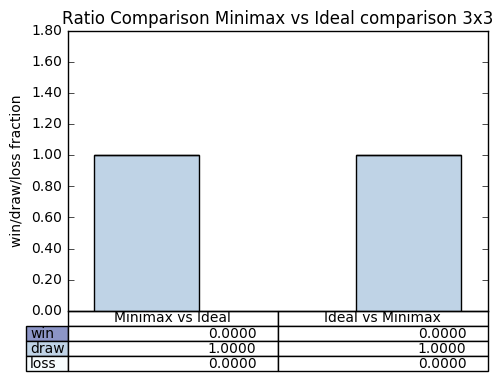

In [19]:
###########################
# Minimax vs Ideal

if __name__ == '__main__': 
    size = 3
    columns  = ('Minimax vs Ideal', 'Ideal vs Minimax')
    start = time()
    ratios = fightDuels([QMap(), QMap()], [['minimax', 'ideal'],
                                           ['ideal', 'minimax'] ], size, n_games = 3, p1qds = [5 , 2], p2ds = [2, 5])
    
    print time() - start        
    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'Minimax vs Ideal comparison 3x3')

Lucky_Q doing its thing

Methodology 
-------------

**Lucky_Q exploration**

An early iteration of the project produced a Q that could tie the perfect players as player1


In [11]:
################################################
# "lucky" Q-learning  vs Ideal and minimax stats

if __name__ == '__main__':  
    size = 3
    with open("./lucky_3x3_Q.pickle", 'rb') as f:
        QM = pickle.load(f)      
        
    ratios = fightDuels([QM, QM, QM, QM, QM, QMap()],
                        [ ['ideal', 'Qlearning'  ],
                          ['Qlearning', 'ideal'  ],
                          ['minimax', 'Qlearning'],
                          ['Qlearning', 'minimax'],
                          ['Qlearning', 'Qlearning'],
                          ['random', 'random'    ]], size, n_games = 100 )
 
    
    cols = ["P1 win",  "draw", "P1 loss"]
    
    rows = ('ideal vs lucky_Q', 'lucky_Q vs ideal',
            'minimax vs lucky_Q', 'lucky_Q vs minimax',
            'lucky_Q vs lucky_Q','random vs random')
    
    table = pd.DataFrame(ratios, columns = cols, index = rows)
    print
    display(table)
    
    #ratios = np.transpose(ratios)
    #graphStats(columns, ratios, 'lucky-Q vs Minimax {}x{}'.format(size,size))

CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'ideal']
CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'minimax']



,P1 win,draw,P1 loss
ideal vs lucky_Q,0.99,0.01,0.00
lucky_Q vs ideal,0.00,1.00,0.00
minimax vs lucky_Q,0.91,0.09,0.00
lucky_Q vs minimax,0.00,1.00,0.00
lucky_Q vs lucky_Q,0.00,1.00,0.00
random vs random,0.61,0.12,0.27


In [10]:
##################################
# "lucky" Q-learn vs Random stats 
    
if __name__ == '__main__':  
    size = 3
    with open("./lucky_3x3_Q.pickle", 'rb') as f:
        QM = pickle.load(f) 
     
    randos = fightDuels([QM, QM, QM, QMap()], [ ['random', 'Qlearning'],
                                                ['Qlearning', 'random'],
                                                ['Qlearning', 'Qlearning'],
                                                ['random', 'random' ]  ], size, n_games = 1000, p1ds = [2,3,3,2], p2ds = [3,2,3,2] )
    cols = ["P1 win",  "draw", "P1 loss"]
    rows = ('random vs lucky_Q',
            'lucky_Q vs random',
            'lucky_Q vs lucky_Q',            
            'random vs random')
    table = pd.DataFrame(randos, columns = cols, index = rows)
    print
    display(table)

CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'Qlearning']



,P1 win,draw,P1 loss
random vs lucky_Q,0.536,0.136,0.328
lucky_Q vs random,0.735,0.107,0.158
lucky_Q vs lucky_Q,0.000,1.000,0.000
random vs random,0.575,0.135,0.290


**Get Lucky again** 

As can be seen on the table displayed when the cell bellow is run, lucky's properties are reproduced after initializing the Q map with alpha 0.1 and gamma 0.1 (aquired through a faux grid search see code in play module).
Here a Q is trained from scratch as described in the report with, 70 trials of random vs random games followed by 1000 of Qlearning vs random, and then 1000 of random vs Qlearning

In [17]:
from strateegery import Strateegery
if __name__ == '__main__':  
    size = 3
    ts = [70, 1000, 1000, 1000] 
    
    QM = QMap(gamma=0.1, alpha=0.1) #Initialize QM with parameters found in faux gridsearch
    
    start = time() 
    QM, tally, conv = playGames(setupGame(QMap(), size, ['random', 'random'],  learning=True), ts[0])   
    # player 2 learning against a random player 1
    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'random'],   learning=True), ts[1])   
    # Now player 1 learning against a random player 2
    QM, tally, conv = playGames(setupGame(QM, size, ['random', 'Qlearning'],   learning=True), ts[2])    
    # Have two agents learn against each other
    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'Qlearning'],learning=True), ts[3])
    print "Training time: " , time() - start 
    
    ##TEST IT
    ratios = fightDuels([QM, QM, QM, QM, QM,QM, QM, QMap()],
                        [ ['ideal', 'Qlearning'  ],
                          ['Qlearning', 'ideal'  ],
                          ['minimax', 'Qlearning'],
                          ['Qlearning', 'minimax'],
                          ['Qlearning', 'Qlearning'],
                          ['random', 'Qlearning'],
                          ['Qlearning', 'random'], 
                          ['random','random'] ], size, n_games = 100 )
 
    
    cols = ["P1 win",  "draw", "P1 loss"]
    
    rows = ('ideal vs lucky_Q', 'lucky_Q vs ideal',
            'minimax vs lucky_Q', 'lucky_Q vs minimax',
            'lucky_Q vs lucky_Q',
            'random vs lucky_Q',
            'lucky_Q vs random',
            'random vs random')
    
    table = pd.DataFrame(ratios, columns = cols, index = rows)
    print
    display(table)

CONVERGENCE ON GAME NUMBER:  32 ['Qlearning', 'Qlearning']
Training time:  15.6409499645
CONVERGENCE ON GAME NUMBER:  0 ['ideal', 'Qlearning']
CONVERGENCE ON GAME NUMBER:  39 ['Qlearning', 'minimax']
CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'Qlearning']



,P1 win,draw,P1 loss
ideal vs lucky_Q,1.00,0.00,0.00
lucky_Q vs ideal,0.00,1.00,0.00
minimax vs lucky_Q,0.73,0.27,0.00
lucky_Q vs minimax,0.00,1.00,0.00
lucky_Q vs lucky_Q,0.00,1.00,0.00
random vs lucky_Q,0.51,0.15,0.34
lucky_Q vs random,0.76,0.15,0.09
random vs random,0.53,0.14,0.33


Refinement
-----------

The following code reproduces results similar to the second half of Table 4 in the refinement section. To get the exact numbers run the code from the terminal, as the IPython notebook does something to mess with the random seed

Training time:  0.0348680019379
CONVERGENCE ON GAME NUMBER:  13 ['Qlearning', 'miniQmax']
CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'miniQmax']
total time:  65.718724966
MiniQmax vs Qlearn Comparison with and without luckyQ


,P1 win,draw,P1 loss
lucky_Qlearn v lucky_Qmax,0.00,1.00,0.00
lucky_Qmax v lucky_Qlearn,0.76,0.24,0.00
luckyQ_learn v miniQmax,0.00,1.00,0.00
miniQmax v lucky_Qlearn,0.91,0.07,0.02


Comparison with random with and without luckyQ


,P1 win,draw,P1 loss
random v lucky_Qmax,0.33,0.07,0.60
lucky_Qmax v random,0.90,0.06,0.04
random v miniQmax,0.26,0.16,0.58
miniQmax v random,0.93,0.03,0.04


CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'miniQmax']
total time:  87.274077177
Final comparison Q uninitialized


,P1 win,draw,P1 loss
Qlearning v miniQmax,0.00,1.00,0.00
miniQmax v Qlearning,0.86,0.09,0.05
random v miniQmax,0.17,0.18,0.65
miniQmax v random,0.90,0.05,0.05


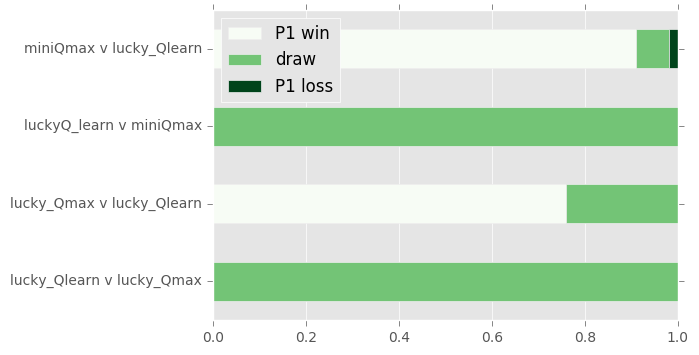

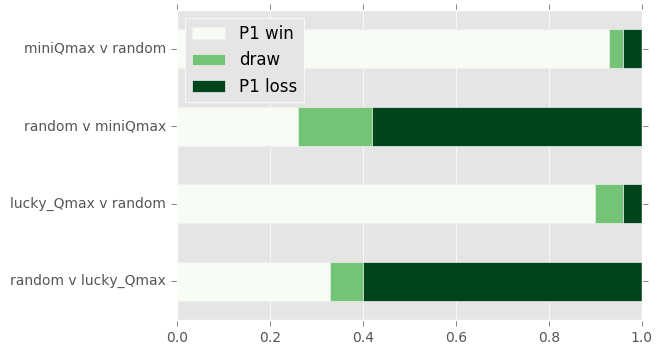

In [5]:
from strateegery import Strateegery

#######################################################
# Compare Qlearning (lucky) with miniQmax different Qs
if __name__ == '__main__':
    with open("./newlucky.pickle", 'rb') as f:
        luckyQ=pickle.load(f)
    size = 3
    ts = [70]
    
    start = time()
    ##########
    #Training
    #Initialize a QMap with just 70 random games played ("Lazy" Q from the report)
    ranQ, tally, conv = playGames(setupGame(QMap(), size, ['random', 'random'],  learning=True), ts[0]) 
    print "Training time: " , time() - start 

    ##########
    #MiniQmax vs Qlearn 
    ratios = [getRatios(setupGame(QMap(), size, ['Qlearning', 'miniQmax'], p1QM=luckyQ, p2QM=luckyQ, d2=3), 100)]
    ratios.append(getRatios(setupGame(QMap(), size, ['miniQmax', 'Qlearning'], p1QM=luckyQ, p2QM=luckyQ, d1=3), 100))
    ratios.append(getRatios(setupGame(QMap(), size, ['Qlearning', 'miniQmax'], p1QM=luckyQ, p2QM=ranQ, d2=3), 100))
    ratios.append(getRatios(setupGame(QMap(), size, ['miniQmax', 'Qlearning'], p1QM=ranQ, p2QM=luckyQ, d1=3), 100))
    
    cols = ('P1 win', 'draw', 'P1 loss')
    
    rows = ['lucky_Qlearn v lucky_Qmax',
            
            'lucky_Qmax v lucky_Qlearn',
            
            'luckyQ_learn v miniQmax',
            
            'miniQmax v lucky_Qlearn']

    table = pd.DataFrame(ratios, columns = cols, index=rows)
    print "total time: " , time()-start
    print "MiniQmax vs Qlearn Comparison with and without luckyQ"
    display(table)
    table.plot.barh(colormap='Greens', stacked=True)
    #plt.show()
    
    ##########
    #Comparison with random with
    ratios  = fightDuels([luckyQ, luckyQ, ranQ, ranQ],
                         [ ['random', 'miniQmax' ],
                           ['miniQmax', 'random' ],
                           ['random', 'miniQmax'],
                           ['miniQmax', 'random' ]], size, n_games = 100 , p1ds = [2,3,2,3], p3ds = [3,2,3,2] )
    
    rws = ['random v lucky_Qmax' ,
            'lucky_Qmax v random' ,
            'random v miniQmax',
            'miniQmax v random' ]
    
    ranTable = pd.DataFrame(ratios, columns=cols, index=rws)
    print "Comparison with random with and without luckyQ"
    display(ranTable)
    ranTable.plot.barh(colormap='Greens',stacked=True)
    # plt.show()

    ###########
    #Final comparison minQmax uninitialized
    start = time()
    duels = [ ['Qlearning','miniQmax' ],
              ['miniQmax', 'Qlearning'],
              ['random', 'miniQmax'   ],
              ['miniQmax','random'    ] ]
    
    start = time()
    ratios = []
    ratios.append(getRatios(setupGame(QMap(), size,duels[0], p1QM=luckyQ, d2=3), 100))
    ratios.append(getRatios(setupGame(QMap(), size,duels[1], p2QM=luckyQ, d1=3), 100))
    ratios.append(getRatios(setupGame(QMap(), size,duels[2], d2=3), 100))
    ratios.append(getRatios(setupGame(QMap(), size,duels[3], d1=3), 100))
    
    print "total time: ", time() - start

    cols = ["P1 win",  "draw", "P1 loss"]
    rows = [r[0] +' v '+r[1] for r in duels]
    ftable = pd.DataFrame(ratios, columns = cols, index=rows)
    print "Final comparison Q uninitialized"
    display(ftable)


Results
---------

CONVERGENCE ON GAME NUMBER:  0 ['miniQmax', 'ideal']
CONVERGENCE ON GAME NUMBER:  0 ['miniQmax', 'minimax']
CONVERGENCE ON GAME NUMBER:  0 ['Qlearning', 'miniQmax']
CONVERGENCE ON GAME NUMBER:  0 ['minimax', 'miniQmax']
CONVERGENCE ON GAME NUMBER:  0 ['ideal', 'miniQmax']
total time:  89.4659910202


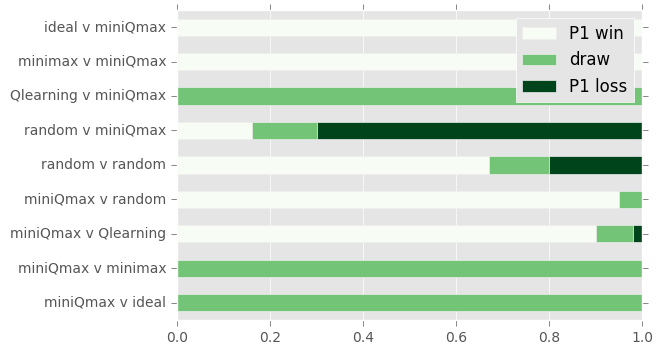

,P1 win,draw,P1 loss
miniQmax v ideal,0.00,1.00,0.00
miniQmax v minimax,0.00,1.00,0.00
miniQmax v Qlearning,0.90,0.08,0.02
miniQmax v random,0.95,0.05,0.00
random v random,0.67,0.13,0.20
random v miniQmax,0.16,0.14,0.70
Qlearning v miniQmax,0.00,1.00,0.00
minimax v miniQmax,1.00,0.00,0.00
ideal v miniQmax,1.00,0.00,0.00


In [8]:
from strateegery import Strateegery
######################################
# Final Comparison miniQmax centric
######################################
if __name__ == '__main__':
    size =3
    with open("./newlucky.pickle") as f:
        luckyQ = pickle.load(f)

    duels = [['miniQmax', 'ideal' ],
             ['miniQmax', 'minimax'],
             ['miniQmax', 'Qlearning'],
             ['miniQmax', 'random'],
             
             ['random', 'random'],
             
             ['random', 'miniQmax'],
             ['Qlearning','miniQmax'],
             ['minimax', 'miniQmax'],
             ['ideal', 'miniQmax'] ]


    start = time()
    ratios = []
    ## As Player 1
    ratios.append(getRatios(setupGame(QMap(), size, duels[0], d1=3              ), 100))
    ratios.append(getRatios(setupGame(QMap(), size, duels[1], d1=3, d2=2        ), 100))
    ratios.append(getRatios(setupGame(QMap(), size, duels[2], d1=3, p2QM=luckyQ ), 100))
    ratios.append(getRatios(setupGame(QMap(), size, duels[3], d1=3              ), 100))

    # Random
    ratios.append(getRatios(setupGame(QMap(), size, duels[4],                   ), 100))
    
    ## As player 2
    ratios.append(getRatios(setupGame(QMap(), size, duels[5], d2=3              ), 100))
    ratios.append(getRatios(setupGame(QMap(), size, duels[6], d2=3, p1QM=luckyQ ), 100))
    ratios.append(getRatios(setupGame(QMap(), size, duels[7], d1=2, d2=3        ), 100))
    ratios.append(getRatios(setupGame(QMap(), size, duels[8], d2=3              ), 100))

    
    print "total time: ", time() - start

    cols = ["P1 win",  "draw", "P1 loss"]
    rows = [r[0] +' v '+r[1] for r in duels]
    fintable = pd.DataFrame(ratios, columns = cols, index=rows)
    fintable.plot.barh(colormap='Greens', stacked=True)
    plt.show()
    display(fintable)